[View in Colaboratory](https://colab.research.google.com/github/cxl923cc/Avito/blob/master/Avito_Image_Analysis.ipynb)

# Avito Demand Prediction

**Step 1 - Preparation:**
  * Import the libraries. Define the threshold of image recognisability
  * Set up Kaggle API
  * Download image data and train master (zipped file), unzip the files
  * Download Resnet50 from keras library

In [0]:
import os

import numpy as np
import pandas as pd
from keras.preprocessing import image
import keras.applications.resnet50 as resnet50
import keras.applications.xception as xception
import keras.applications.inception_v3 as inception_v3
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from datetime import datetime
import zipfile
import cv2
from google.colab import files

#Set threshold of recognisability
p_top_thresh = 0.8

In [1]:
#@title
!pip install kaggle

  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /content/.cache/pip/wheels/98/be/57/a576a1f2f50f5c3bebd0c08fc3b2a6881dfde31c8217014978
Successfully built kaggle


In [2]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [9]:
!kaggle competitions list

ref                                             deadline             category            reward  teamCount  userHasEntered  
----------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
imagenet-object-detection-challenge             2029-12-31 07:00:00  Research         Knowledge          0           False  
imagenet-object-detection-from-video-challenge  2029-12-31 07:00:00  Research         Knowledge          0           False  
imagenet-object-localization-challenge          2029-12-31 07:00:00  Research         Knowledge          8           False  
titanic                                         2020-04-07 00:00:00  Getting Started  Knowledge      11190            True  
house-prices-advanced-regression-techniques     2020-03-01 23:59:00  Getting Started  Knowledge       5243            True  
digit-recognizer                                2020-01-07 00:00:00  Getting Started  Knowledge       2396           False  


In [4]:
!kaggle competitions files -c avito-demand-prediction

name                    size  creationDate         
---------------------  -----  -------------------  
sample_submission.csv    8MB  2018-04-23 21:26:51  
test_jpg.zip            19GB  2018-04-23 22:09:42  
train_jpg.zip           49GB  2018-04-23 23:06:39  
test.csv.zip           107MB  2018-04-24 18:25:00  
periods_test.csv.zip   136MB  2018-04-24 18:25:02  
periods_train.csv.zip  170MB  2018-04-24 18:25:04  
train.csv.zip          308MB  2018-04-24 18:26:58  
test_active.csv.zip      2GB  2018-04-24 18:31:08  
train_active.csv.zip     3GB  2018-04-24 18:44:13  
train_jpg_4.zip         10GB  2018-05-01 22:40:01  
train_jpg_2.zip         10GB  2018-05-01 22:40:05  
train_jpg_1.zip         10GB  2018-05-01 22:40:06  
train_jpg_0.zip         10GB  2018-05-01 22:40:06  
train_jpg_3.zip         10GB  2018-05-01 22:40:06  


In [5]:
!kaggle competitions download -c avito-demand-prediction -f train_jpg_0.zip   
!kaggle competitions download -c avito-demand-prediction -f train_jpg_1.zip  
!kaggle competitions download -c avito-demand-prediction -f train_jpg_2.zip 
!kaggle competitions download -c avito-demand-prediction -f train_jpg_3.zip 
!kaggle competitions download -c avito-demand-prediction -f train_jpg_4.zip 
#2 mins

train_jpg_0.zip: Downloaded 10GB of 10GB


In [4]:
!kaggle competitions download -c avito-demand-prediction -f train.csv.zip

train.csv.zip: Downloaded 308MB of 308MB


In [5]:
!unzip .kaggle/competitions/avito-demand-prediction/train.csv.zip
#After unzip, train.csv is under the home folder

Archive:  .kaggle/competitions/avito-demand-prediction/train.csv.zip
  inflating: train.csv               


In [6]:
!ls .kaggle/competitions/avito-demand-prediction/

train.csv.zip  train_jpg_4.zip


In [8]:
resnet_model = resnet50.ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 7s 0us/step


**Step 2 - Read Data:**
  * Read train master file into a dataframe 'train_df'
  * Read all the images from the zipped image archive

In [9]:
train_df = pd.read_csv('train.csv')
train_df.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


In [0]:
#Specify the zip archive
def read_zip(i):
    print('processing train_jpg_' + i)

    start=datetime.now()

    #Create directory to store the images extracted from the zip archive
    images_dir = os.path.expanduser(os.path.join('~', 'avito_images'+i))
    if not os.path.exists(images_dir):
        os.makedirs(images_dir)

    #Extract images and save them under the directory
    with zipfile.ZipFile('.kaggle/competitions/avito-demand-prediction/train_jpg_'+ i +'.zip', 'r') as train_zip:
        files_in_zip = sorted(train_zip.namelist())
        for idx, file in enumerate(files_in_zip):
            if file.endswith('.jpg'):
                train_zip.extract(file, path=images_dir)

    #Scan all the images under the directory and save their path to a list that will be used to read the images
    image_files = [x.path for x in os.scandir('/content/avito_images' + i)]
    print('Total number of images read into the image directory: ', len(image_files))

    print (datetime.now()-start)
    
    return image_files


**Step 3 - Make Prediction:**
  * Make predictions on all images and take the top predicted class
  * Set the confidence threshold as 0.8 meaning when ResNet is 80% sure about the top predicted class, we assume the image is recognisable and assign a flag ('flag_clear_img') 1 to the image, otherwise 0.
  * Note: Few damaged images - train_jpg_0.zip has 278168 images but there are 2 damaged ones that can not be opened
  * Potential improvements: Add another two networks; compare similarity between the top 2 categories


In [0]:
#Create a flag to identify whether the top probability is larger than 80%
#Set threshold of the prediction for the most likely class

def extract_img_f(image_files):  
    start=datetime.now()

    #Set the total number of images
    tot_num_image = len(image_files)

    list_img_id = []
    list_flag_clear_img = []
    list_img_size = []
    list_img_shape_ratio = []

    for i in range(0, tot_num_image):
        flag_clear_img = 0
        #Skip the damaged images that exist but can not be opened, e.g. image_files[270883] exists but can't be opened
        if cv2.imread(image_files[i]) is not None:
            img = Image.open(image_files[i])
            #Get image size and the shape ratio (width/height)
            image_size = img.size[0]*img.size[1]
            image_shape_ratio = img.size[0]/img.size[1]
            """Classify image and return top matches."""
            target_size = (224, 224)
            if img.size != target_size:
                img = img.resize(target_size)
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = resnet50.preprocess_input(x)
            preds = resnet_model.predict(x)
            resnet_preds = resnet50.decode_predictions(preds, top=3)[0]
            #Top probability
            if resnet_preds[0][2] > p_top_thresh:
                flag_clear_img = 1
            list_flag_clear_img.append(flag_clear_img)

            list_img_size.append(image_size)
            list_img_shape_ratio.append(image_shape_ratio)
            list_img_id.append(image_files[i].split('/')[-1].replace('.jpg',''))
        #print(resnet_preds)
        
    df = pd.DataFrame({'image_id': list_img_id,
                       'flag_clear_img': list_flag_clear_img,
                       'image_size': list_img_size,
                       'image_shape_ratio': list_img_shape_ratio})
    
    print (datetime.now()-start)
    
    return df


**Step 4 - Compare the deal probability of the recognisable and unrecognisable group:**
  * The average deal probability on the recognisable is slightly higher than the unrecognisable group. It is more obvious on the 10000 sample (16.3% vs 13.9%) than the 1000 sample (14.7% vs 13.1%).

In [0]:
def report_export(df, i):
    #Check how different the deal probability on the recognisable (ResNet is more than 80% confident) and unrecognisable images (ResNet is <= 80% confident)
    df_w_target = pd.merge(df, train_df, how = 'left', left_on='image_id', right_on='image')
    print('check missing rate from merge:', df_w_target.deal_probability.isnull().sum())
    print(df_w_target.groupby(df_w_target['flag_clear_img'])['deal_probability'].agg(['count','sum','mean','min','max','median']))
    sns.factorplot(data = df_w_target, x = 'flag_clear_img', y = 'deal_probability', kind = 'box')
    plt.show()
    #Histogram
    df_w_target.loc[df_w_target.flag_clear_img == 0]['deal_probability'].plot.hist()
    plt.title('Unrecognisable image')
    plt.show()
    df_w_target.loc[df_w_target.flag_clear_img == 1]['deal_probability'].plot.hist()
    plt.title('Recognisable image')
    plt.show()
    
    df_w_target[['image_id','flag_clear_img','image_size','image_shape_ratio']].to_csv('train_jpg_'+ i + '.csv')
    files.download('train_jpg_'+ i + '.csv')


In [13]:
# Call the functions
image_files0 = read_zip(i = '0')
df0 = extract_img_f(image_files = image_files0)
report_export(df = df0, i = '0')

image_files1 = read_zip(i = '1')
df1 = extract_img_f(image_files = image_files1)
report_export(df = df1, i = '1')

image_files2 = read_zip(i = '2')
df = extract_img_f(image_files = image_files2)
report_export(df = df, i = '2')

image_files3 = read_zip(i = '3')
df3 = extract_img_f(image_files = image_files3)
report_export(df = df3, i = '3')

image_files4 = read_zip(i = '4')
df4 = extract_img_f(image_files = image_files4)
report_export(df = df4, i = '4')

'''
====== Runtime =======
Loading images takes 10 mins, prediction takes ~1 hour per 100k images, so total run time is about 3.5 hours per zip archive

================== Results On 0_zip images ==================
                 count          sum      mean  min  max  median
flag_clear_img                                                 
0               226768  30329.68297  0.133748  0.0  1.0     0.0
1                51398   7346.91666  0.142942  0.0  1.0     0.0
================== Results On 1_zip images ==================
                 count          sum      mean  min  max  median
flag_clear_img                                                 
0               226774  30132.30750  0.132874  0.0  1.0     0.0
1                51392   7357.39799  0.143162  0.0  1.0     0.0
================== Results On 2_zip images ==================
                 count          sum      mean  min  max  median
flag_clear_img                                                 
0               227169  30279.05575  0.133289  0.0  1.0     0.0
1                50997   7282.34254  0.142799  0.0  1.0     0.0
================== Results On 3_zip images ==================
                 count          sum      mean  min  max  median
flag_clear_img                                                 
0               226806  30276.31462  0.133490  0.0  1.0     0.0
1                51361   7261.14626  0.141375  0.0  1.0     0.0
================== Results On 4_zip images ==================
                 count          sum      mean  min  max  median
flag_clear_img                                                 
0               226929  30202.73535  0.133093  0.0  1.0     0.0
1                51238   7200.08444  0.140522  0.0  1.0     0.0
'''

processing train_jpg_4
Total number of images read into the image directory:  278167
0:11:22.140258
40960/35363 [==================================] - 0s 3us/step
3:11:12.884755


check missing rate from merge: 0
                 count          sum      mean  min  max  median
flag_clear_img                                                 
0               226929  30202.73535  0.133093  0.0  1.0     0.0
1                51238   7200.08444  0.140522  0.0  1.0     0.0


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


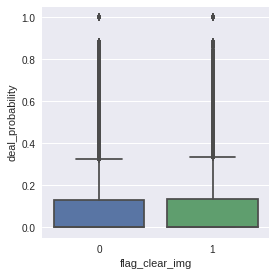

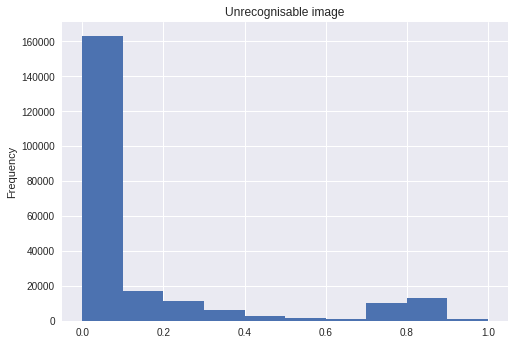

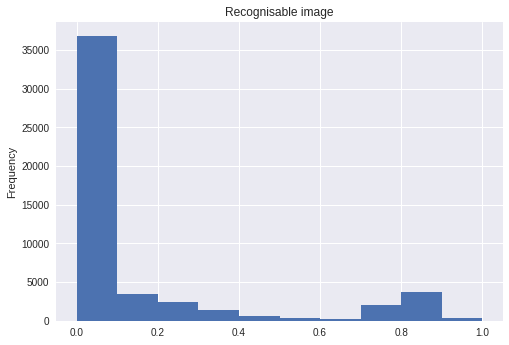

In [14]:
#@title
#report_export(df = df4, i = '4')